In [1]:
import cv2               #for image read, flip, crop etc
import csv               #for csv file operation
import numpy as np       #for numpy array operation
import os                #for directory operation
import sklearn           #for yield, util etc
from sklearn.model_selection import train_test_split    # split train test data

#for model
from keras.models import Sequential, Model
from keras.layers import Flatten, Dense, Lambda, Conv2D, Cropping2D, Dropout
from keras.layers.pooling import MaxPooling2D
import matplotlib.pyplot as plt
%matplotlib inline


def getRelativeImagePath(dataPath, line):
    """
    @description:      This module gets relative image path from absolution path
    @param line:       line read from driving log csv
    @return newLine:   new line with relative path
    @example input:    /Users/udacity/CarND-Behavioral-Cloning-P3/data/IMG/center_2017_12_02_17_49_38_331.jpg
    @example output:   ./data/IMG/center_2017_12_02_17_49_38_331.jpg
    """
    source_path = line
    filename = source_path.split('/')[-1]
    newLine = dataPath +'/IMG/'+filename.strip()
    return newLine

def getLinesFromDrivingLogs(dataPath, skipHeader=True):
    """
    @description:      This module get list of lines from driving_log.csv
    @param dataPath:   data path where data is stored
    @param skipHeader: default false, true to skip header in csv
    @return:           array of lines
    """
    lines = []
    with open(dataPath + '/driving_log.csv') as csvFile:
        reader = csv.reader(csvFile)
        if skipHeader:
            next(reader, None)
        for line in reader:
            lines.append(line)
    return lines

C:\Users\GANESHA\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def combineImagesAndMeasurementsCorrection(center, left, right, measurement, correction):
    """
    @description: combine image paths from center, left, right using correction
    @center:      center image path
    @left:        left image path
    @right:       right image path
    @return:      array of imagePath and measurements
    """
    imagePaths = []
    imagePaths.extend(center)
    imagePaths.extend(left)
    imagePaths.extend(right)
    measurements = []
    measurements.extend(measurement)
    measurements.extend([x + correction for x in measurement])
    measurements.extend([x - correction for x in measurement])
    return (imagePaths, measurements)

In [3]:
def getImages(dataPath):
    """
    @description:     This module gets center, left, right and 
                      total measurement(stearing) using driving log csv    
    @param dataPath:  data path where data is stored
    @return:          array of center, left, right path and measurement(stearing)
    """
    directories = [x[0] for x in os.walk(dataPath)]
    dataDirectories = list(filter(lambda directory: os.path.isfile(directory + '/driving_log.csv'),directories))
    centerTotal = []
    leftTotal = []
    rightTotal = []
    measurementTotal = []
    print(dataDirectories)
    for directory in dataDirectories:
        lines = getLinesFromDrivingLogs(directory)
        center = []
        left = []
        right = []
        measurements = []
        for line in lines:
            measurements.append(float(line[3]))
            center.append(getRelativeImagePath(dataPath,line[0]))
            left.append(getRelativeImagePath(dataPath,line[1]))
            right.append(getRelativeImagePath(dataPath,line[2]))
        centerTotal.extend(center)
        leftTotal.extend(left)
        rightTotal.extend(right)
        measurementTotal.extend(measurements)

    return (centerTotal, leftTotal, rightTotal, measurementTotal)

In [4]:
def generator(samples, batch_size=32):
    """
    @description:      generates required images and measurement 
                       using sample(training/validation) in batches of batch size
    @param samples:    list of pairs containing imagePath and measuremnet
    @param batch_size: batch size to generate data, default is 32 
    """
    num_samples = len(samples)
    while 1: # Loops forever, generator never ends
        samples = sklearn.utils.shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for imagePath, measurement in batch_samples:
                originalImage = cv2.imread(imagePath)
                image = cv2.cvtColor(originalImage, cv2.COLOR_BGR2RGB)
                images.append(image)
                angles.append(measurement)
                # Data augment: Flipping images
                images.append(cv2.flip(image,1))
                angles.append(measurement*-1.0)

            # Data augment: trim image to only see section with road
            inputs = np.array(images)
            outputs = np.array(angles)
            yield sklearn.utils.shuffle(inputs, outputs)

In [5]:
# Reading images.
centerPaths, leftPaths, rightPaths, measurements = getImages('data')
imagePaths, measurements = combineImagesAndMeasurementsCorrection(centerPaths, leftPaths, rightPaths, measurements, 0.2)
print('Total Images: {}'.format( len(imagePaths)))

['data']
Total Images: 24108


In [6]:
# Splitting samples into training and validation samples
samples = list(zip(imagePaths, measurements))
train_samples, validation_samples = train_test_split(samples, test_size=0.2)

print('Train samples: {}'.format(len(train_samples)))
print('Validation samples: {}'.format(len(validation_samples)))

Train samples: 19286
Validation samples: 4822


In [7]:
# Creating train and validation generators.
train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)

In [8]:
def getNvidiaModel():
    """
    @description: NVIDIA CNN model for keras 2
    """
    model = Sequential()
    model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(160,320,3)))
    model.add(Cropping2D(cropping=((50,20), (0,0)),input_shape=(160, 320, 3)))
    model.add(Conv2D(24, (5, 5), activation="relu", strides=(2, 2)))
    model.add(Conv2D(36, (5, 5), activation="relu", strides=(2, 2)))
    model.add(Conv2D(48, (5, 5), activation="relu", strides=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation="relu"))
    model.add(Conv2D(64, (3, 3), activation="relu"))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(100))
    model.add(Dropout(0.5))
    model.add(Dense(50))
    model.add(Dense(10))
    model.add(Dense(1))
    return model
# Creating Model
model = getNvidiaModel()

# Compiling and training the model
model.compile(loss='mse', optimizer='adam')
 
model.summary()

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 160, 320, 3)       0         
_________________________________________________________________
cropping2d_1 (Cropping2D)    (None, 90, 320, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 43, 158, 24)       1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 77, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 37, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 6, 35, 64)         27712  

In [9]:
batch_size=32
history = model.fit_generator(train_generator, steps_per_epoch=(len(train_samples)/batch_size),
            validation_data=validation_generator,validation_steps=(len(validation_samples)/batch_size),
                              epochs=4, verbose=1)
    
model.save('model.h5')

#generate_arrays_from_file('/my_file.txt'),steps_per_epoch=10000, epochs=10)
#fit_generator(generator, steps_per_epoch=None, epochs=1, verbose=1, callbacks=None, validation_data=None, validation_steps=None, validation_freq=1, class_weight=None, max_queue_size=10, workers=1, use_multiprocessing=False, shuffle=True, initial_epoch=0)

Epoch 1/4
603/602 [==============================] - 1021s - loss: 0.0357 - val_loss: 0.0163
Epoch 2/4
603/602 [==============================] - 1101s - loss: 0.0165 - val_loss: 0.0153
Epoch 3/4
603/602 [==============================] - 922s - loss: 0.0155 - val_loss: 0.0144
Epoch 4/4
603/602 [==============================] - 898s - loss: 0.0150 - val_loss: 0.0140


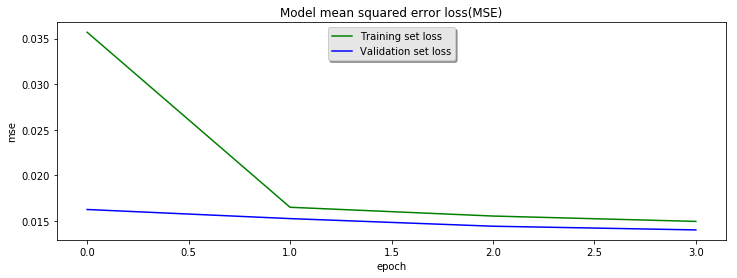

In [10]:
fig, ax = plt.subplots(figsize=(12,4))
plt.plot(history.history['loss'], color='green', label='Training set loss')
plt.plot(history.history['val_loss'], color='blue', label='Validation set loss')
plt.title('Model mean squared error loss(MSE)')
plt.ylabel('mse')
plt.xlabel('epoch')
legend = ax.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')